In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import xarray as xr
import pandas as pd
import pycomlink as pycml

# Load and preprocess example data 

These steps are similar to the steps performed in the notebook "Basic CML processing workflow.ipynb". 

In [4]:
# Load data
data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + '/example_cml_data.nc')

# select 3 different CMLs to study
cmls = cmls.isel(cml_id = [0, 10, 370])

# Remove outliers, compute tl and interpolate missing values
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['tl'] = cmls.tsl - cmls.rsl # calculate total loss (previous TRSL)
cmls['tl'] = cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# Do wet-dry classification and determine baseline

This compares 3 different ways of finding wet and dry periods in the CML time series.

**Update**: As tensorflow was removed, so were the methods using neural networks. Hence only one method (the rolling standard deviation method) is shown here.

In [5]:
# wet dry detection using rsd
cmls['wet_rsd'] = cmls.tl.rolling(time=60, center=True).std() > 0.8

In [7]:
# Determine baseline for the 
cmls['baseline_rsd'] = pycml.processing.baseline.baseline_constant(trsl=cmls.tl, wet=cmls.wet_rsd, n_average_last_dry=5)

### Plot TL and baseline for good CML

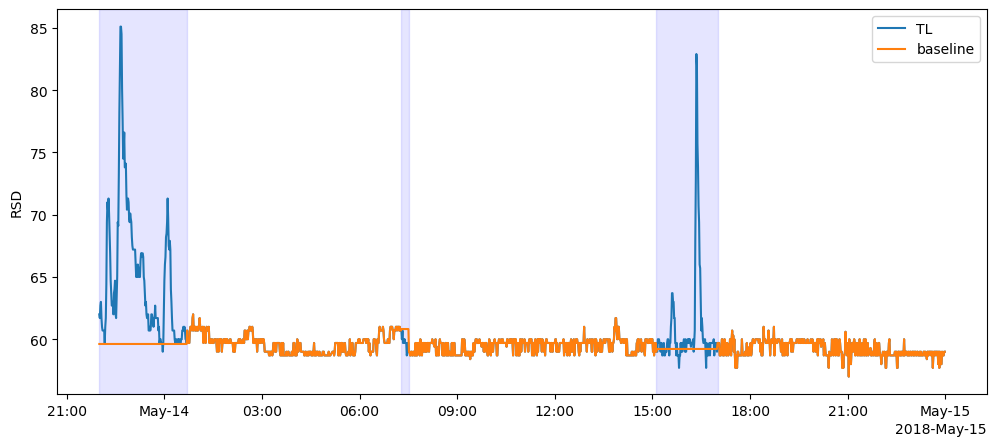

In [8]:
start = '2018-05-13T22'
end = '2018-05-14'
cml_plot = cmls.sel(time = slice(start, end)).isel(cml_id = 0, channel_id = 0)

# convert float to bool for plotting the shaded areas
cml_plot['wet_rsd'] = cml_plot.fillna(0).wet_rsd.astype(bool)

fig, ax = plt.subplots(figsize=(12,5), sharex=True)
cml_plot.tl.plot.line(x='time', ax=ax, label = 'TL');

# shaded rsd
cml_plot['wet_rsd'][0] = 0 
cml_plot['wet_rsd'][-1] = 0 
wet_start = np.roll(cml_plot.wet_rsd, -1) & ~cml_plot.wet_rsd
wet_end = np.roll(cml_plot.wet_rsd, 1) & ~cml_plot.wet_rsd
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax.axvspan(cml_plot.time.values[wet_start_i], cml_plot.time.values[wet_end_i], color='b', alpha=0.1)

cml_plot.baseline_rsd.plot.line(x='time', ax=ax, label ='baseline');

ax.set_title('');
ax.set_xlabel('')
ax.set_ylabel('RSD')

ax.legend(loc = 'upper right')

#### Notes: 

- The RSD method identifies 3 rainy periods. 
- ~~The MLP method is able to identify several rainy periods around 16:00.
- ~~The CNN generally estimates longer wet periods.

### Plot TL and baseline for a less good CML

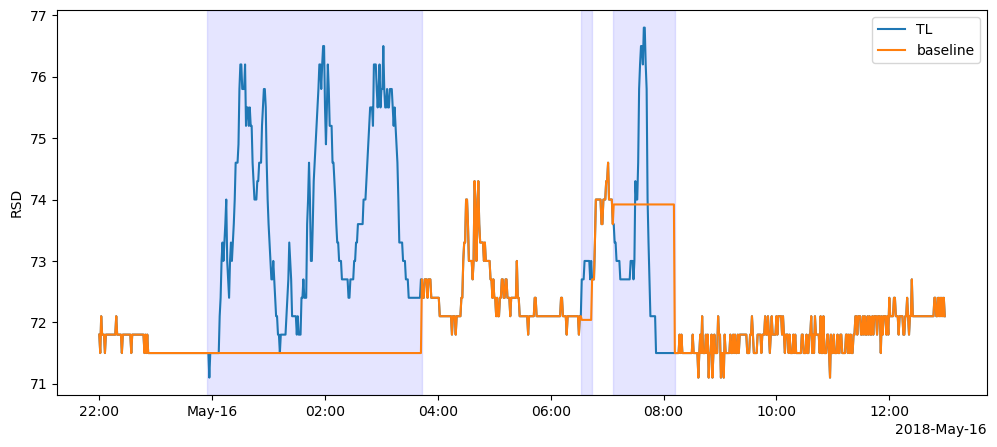

In [9]:
start = '2018-05-15T22'
end = '2018-05-16T12'
cml_plot = cmls.sel(time = slice(start, end)).isel(cml_id = 2, channel_id = 0)

# convert float to bool for plotting the shaded areas
cml_plot['wet_rsd'] = cml_plot.fillna(0).wet_rsd.astype(bool)

fig, ax = plt.subplots(figsize=(12,5), sharex=True)
cml_plot.tl.plot.line(x='time', ax=ax, label = 'TL');

# shaded rsd
cml_plot['wet_rsd'][0] = 0 
cml_plot['wet_rsd'][-1] = 0 
wet_start = np.roll(cml_plot.wet_rsd, -1) & ~cml_plot.wet_rsd
wet_end = np.roll(cml_plot.wet_rsd, 1) & ~cml_plot.wet_rsd
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax.axvspan(cml_plot.time.values[wet_start_i], cml_plot.time.values[wet_end_i], color='b', alpha=0.1)

cml_plot.baseline_rsd.plot.line(x='time', ax=ax, label ='baseline');

ax.set_title('');
ax.set_xlabel('')
ax.set_ylabel('RSD')

ax.legend(loc = 'upper right')

#### Notes: 
- The RSD method finds the two largest events, but does not predict rainfall at 04:30.
- ~~The MLP method predicts rainfall at 04:30. 
- ~~The CNN generally estimates longer wet periods.  